# [Quantization](https://jin-choi.tistory.com/18)

## What is Quantization?
- Quantization이라는 용어가 비단 딥러닝에 국한된 것은 아닙니다. 위키피디아에 의하면, 촘촘한 값들을 듬성듬성하게 맵핑했다, 라고 대충 이해할 수 있습니다.

### 일상 속에서의 예시

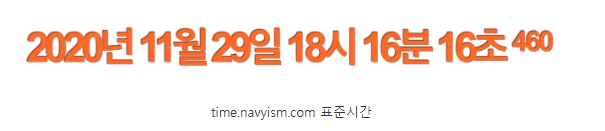

누군가 현재 시간을 물어봤다고 가정합시다.

- "현재 시각은 2020년 11월 29일 18시 16분 16초 460밀리초야", 라고 답변해줄 수도 있겠습니다.
- 하지만 "18시 16분"이라고 답변해도 괜찮을 것이며, 더 나아가서는 "6시 반"이라고만 해줘도 충분할 것입니다.

정확한 현재 시각까지 알아야 할 필요가 없을때 적당히 precision이 낮은 값을 제공하는 것, 우리는 이미 quantization을 일상 속에서 사용하고 있습니다.

### 딥러닝에서의 예시

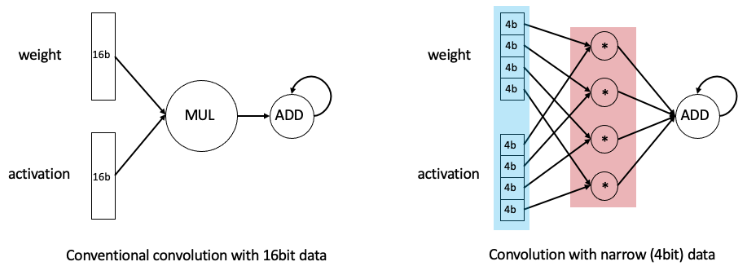

딥러닝 모델의 weight과 activation를 나타내는 bit 수를 줄이는 것에 응용을 할 수 있습니다. 이렇게 bit 수를 줄일 경우 크게 두 가지 이점이 있습니다.
1. 데이터를 표헌하는 bit 수가 줄어들기 때문에 모델이 차지하는 메모리 공간이 작아집니다.
2. 실행할 수 있는 연산의 수가 많아집니다.

`2. 실행할 수 있는 연산의 수가 많아진다.`에 대해 부연 설명을 하기 위해 위 그림을 삽입했습니다. 좌측(Conventional convolution with 16bit data)에서는 16bit짜리 데이터의 곱셈과 덧셈을 수행하고 있는 반면, 우측(Convolution with narrow 4bit data)에서는 4bit짜리 곱셈 네 번을 병렬적으로 수행한 뒤 덧셈을 수행하고 있습니다. 인풋 데이터를 표현하는 bit 수가 줄어들기 때문에, 동일한 하드웨어로 같은 시간 동안 수행할 수 있는 연산의 수가 더 많아지는 것입니다.

## [부동소수점(floating point)](https://modulabs.co.kr/blog/fixed-points-and-floating-points-how-computers-understand-numbers/)

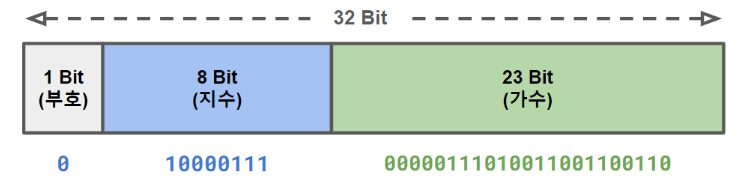

부동소수점 수는 가수(mantissa)와 지수(exponent)로 구분하여 표현합니다.
- `부호(bit)`: 양수이므로 0입니다.
- `정규화`: 263.3 을 2진수로 변환하면 100000111.01001100110011001100110011...(무한반복)이고, 정규화를 통해 1.0000011101001100110011001100110011... * 2^8로 표현할 수 있습니다.
- `가수(mantissa)`: 소수점 이하 부분을 사용합니다. 필요하다면 23비트로 맞추기 위해 뒷부분을 잘라내거나 0으로 채웁니다.
- `지수(exponent)와 Bias`: 지수는 8이고, IEEE 754 표준에서는 32비트 부동소수점의 경우 지수에 127(Bias)를 더한 값을 사용합니다. 따라서, 지수 부분은 8 + 127 = 135, 2진수로 10000111.

### bfloat16(Brain Floating Point Format)

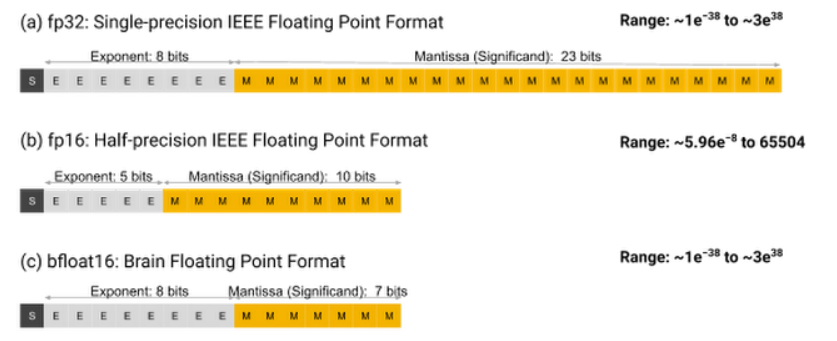

- 위 그림에서 볼 수 있듯이, 기존의 부동소수점 포맷인 float32는 (exponent 8bit) + (mantissa 23bit)로 구성되고, float16는 (exponent 5bit)과 (mantissa 10bit)로 구성됩니다.
- 그러던 중, Google Brain에서는 bfloat16(Brain Floating Point Format)라는 새로운 포맷을 제시합니다. bfloat16는 (exponent 8bit)를 사용함으로써 float32만큼 넓은 range를 표현하되, (mantissa 7bit)를 사용함으로써 precision을 희생하는 부동소수점 포맷입니다.
- bfloat16 포맷은 구글에 의해 개발된 이후, 구글과 인텔에서 채택되어 실제 hardware accelerator에 적용되어 왔습니다.

여기서 더 나아가, 8bit만으로도 충분하다면서 구글과 Nvidia에서 솔루션을 각각 제시하였습니다. 각각에 대해 설명해보겠습니다.

## Int 8 Quantization - Google's solution

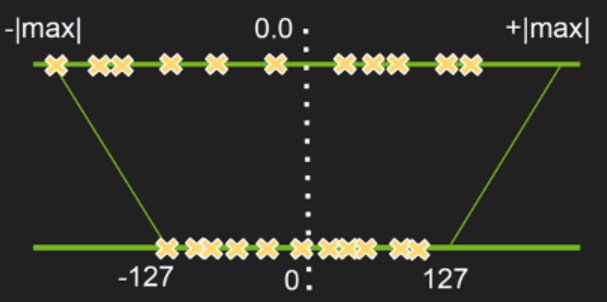

- Google에서 제시한 Int 8bit solution은 위 그림 한 장으로 요약할 수 있습니다.
- 상단의 노란색 격자(x) 표시들이 기존의 float 데이터를 의미하고, 하단의 노란색 격자(x)표시들이 quantize된 integer 데이터를 나타냅니다.

이를 수식적으로 이해해보도록 하겠습니다. 우선 간단한 예제를 통해 32-bit float를 8-bit integer로 변환시키는 방법을 살펴본 뒤, 이를 통해 float로 구성된 행렬의 곱셈 연산을 integer 연산으로 치환할 수 있음을 확인해보겠습니다.

### 32-bit float => 8-bit unsigned integer
- 기존의 float 데이터 r이 주어졌을 때, 이를 S만큼 scale해주고 원점을 Z만큼 이동해주면 정수 데이터 q를 얻게 됩니다.
- 즉, S와 Z가 주어진다면 기존 분포의 데이터를 모두 quantize시킬 수 있습니다.

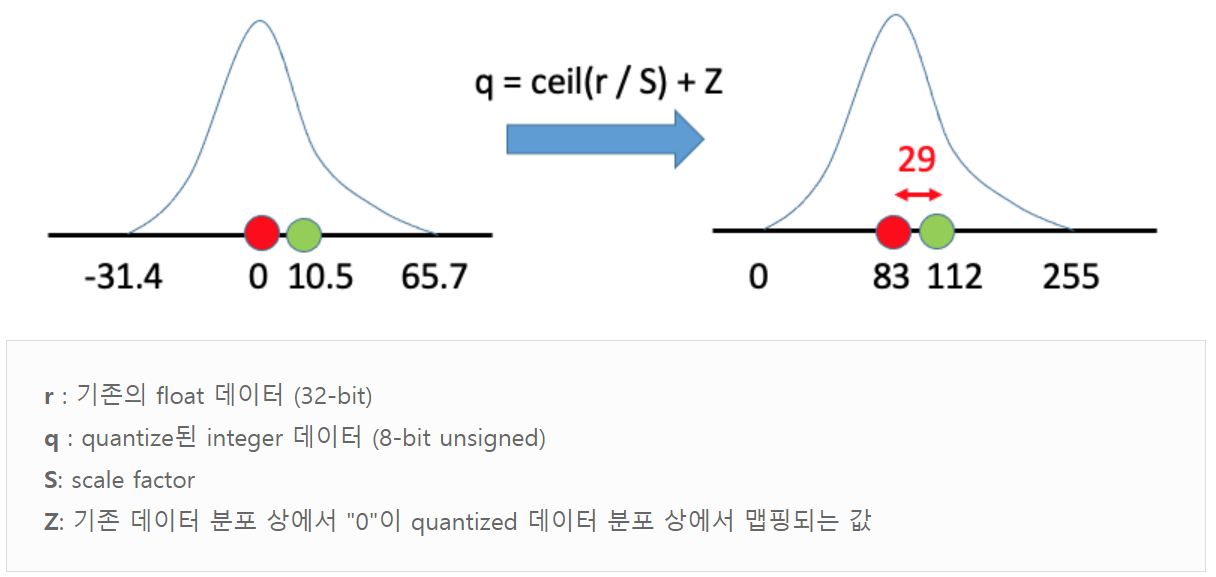

### 32-bit float => 8-bit signed integer (zero-point quantization)
- Z를 0으로 설정함으로써 연산을 더욱 간결하게 할 수 있습니다.
- 하지만 모든 것에는 tradeoff가 있는 법! 이러한 `zero-point quantization`에서는 computation이 줄어드는 만큼 accuracy도 함께 줄어드는 경향이 관찰됩니다.

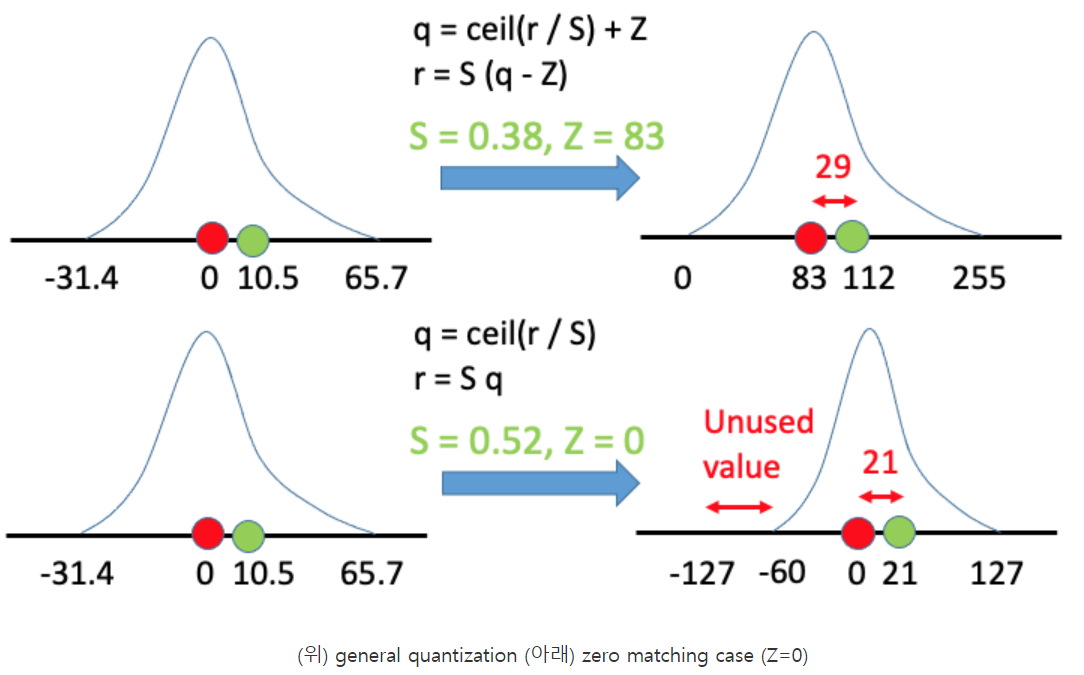

Z가 83에서 0이 되면서 두 가지 변화가 생겼습니다.
- 첫째, scale factor인 S가 0.38에서 0.52로 커졌고,
- 둘째, quantized 데이터의 분포 상에서 -127에서 -60까지의 범위는 사실상 안 활용되고 있음을 관찰할 수 있습니다.

이러한 요인들로 인해 zero matching case에서는 precision이 더 낮아지는 결과가 나타났습니다. 즉, Z=0으로 설정할 경우 matrix computation이 가벼워지는 계산 상의 이점이 있으나, precision이 낮아진다는 tradeoff가 존재합니다.

## Int 8 Quantization - Nvidia's solution
- Google의 INT8 solution을 요약하자면, 기존 분포에서 절댓값이 가장 큰 값을 127(또는 -127)로 맵핑하는 것입니다. 이러한 단순한 방식에서는 quantization error가 클 수 밖에 없습니다.
- quantization error는 맵핑되는 기존 분포의 데이터 범위 크기에 비례합니다. 이러한 점을 고려하여 precision을 개선하고자 한 Nvidia의 INT8 solution입니다.

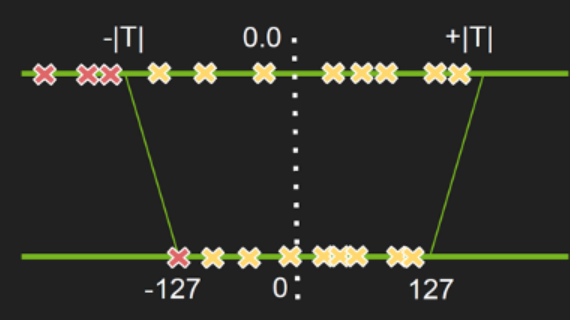

- NVIDA에서 제시하는 Int 8bit solution에서는, truncation을 통해 기존 분포의 데이터 범위를 좁혀버립니다.
- 특정 threshold T를 넘어서는 값들을 모두 T로 truncate시켜준 뒤, -|T|~|T| 범위의 데이터를 -127~127 범위로 맵핑하는 것입니다.
- 이렇게 되면 기존 분포의 데이터 범위가 줄어들기 때문에, quantization error가 감소하게 됩니다.
- 하지만, 양 극단의 값들에서는 truncation error가 발생하겠죠. 이를테면 threshold가 "200"일 경우, "984"도 "201"도 모두 "200"으로 truncate되기 때문입니다.
- 즉 이러한 truncation error를 고려해야 하기 때문에, threshold값 T를 어떻게 정할지가 중요해집니다.

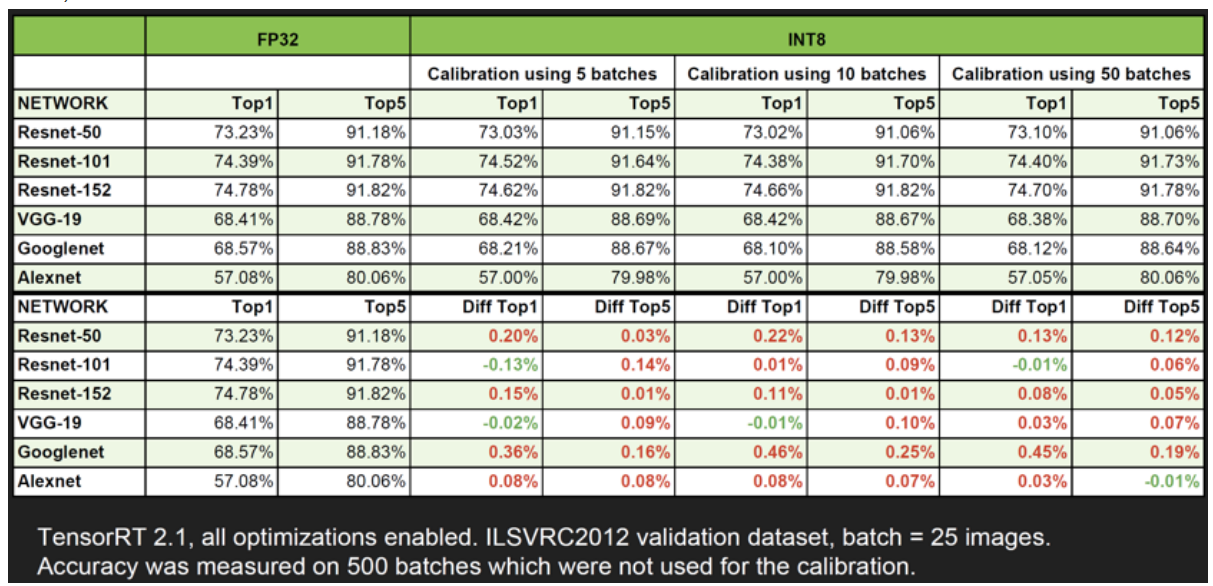

- Threshold값 T를 어떤 값으로 설정하는 게 좋을까요? 쉽게 생각해서, information loss가 가장 작아지게끔 threshold 값을 설정해야겠죠.
- Threshold 값의 모든 후보들에 대해 KL divergence(기존 분포: P, quantize된 분포: Q)를 계산한 뒤 loss가 최소화되는 값으로 T를 설정하는 것이 Nvidia에서 제시한 solution입니다.

위 표에서 볼 수 있듯이, 이러한 Nvidia Int 8 solution을 적용시켜도 accuracy loss가 크지 않다는 사실을 확인할 수 있습니다.

# [예제 - Weight Quantization](https://mlabonne.github.io/blog/posts/Introduction_to_Weight_Quantization.html)

In [1]:
!pip install -q bitsandbytes>=0.39.0
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

# Set device to CPU for now
device = 'cpu'

## 모델 정의
- GPT-2용 모델과 토크나이저를 로드하는 것부터 시작합니다.

In [3]:
# Load model and tokenizer
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model size: 510,342,192 bytes


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 양자화 정의
이 섹션에서는 절대 최대 양자화(Absmax Quantization)를 사용하는 대칭형 양자화와 영점 양자화(Zero point Quantization)를 사용하는 비대칭형이라는 두 가지 양자화 기술을 구현합니다 .

In [4]:
def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

In [5]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = 255 / x_range

    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant

-  다음 단계는 영점 및 절대값 양자화를 사용하여 가중치를 양자화하는 것으로 구성됩니다.
- 다음 예에서는 이러한 기술을 GPT-2의 첫 번째 주의 계층에 적용하여 결과를 확인합니다.

In [6]:
# Extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

# Quantize layer using absmax quantization
weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# Quantize layer using absmax quantization
weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]])

Absmax quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], dtype=torch.int8)

Zero-point quantized weights:
tensor([[-20, -11,  -3,  ...,   3,  -2,   2],
        [  5,   8,  12,  ...,  -1,   0,   0],
        [  1,   4,  18,  ...,   6,   3,   0],
        ...,
        [-11,   0,  10,  ...,  

## 양자화 모델에 적용하기
- PyTorch는 기본적으로 INT8 행렬 곱셈을 허용하지 않습니다.
- 실제 시나리오에서는 모델을 실행하기 위해 이를 역양자화하고(예: FP16에서) INT8로 저장합니다.
- 다음 섹션에서는 bitsandbytes라이브러리를 사용하여 이 문제를 해결해 보겠습니다.

In [7]:
import numpy as np
from copy import deepcopy

# Store original weights
weights = [param.data.clone() for param in model.parameters()]

# Create model to quantize
model_abs = deepcopy(model)

# Quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

# Create model to quantize
model_zp = deepcopy(model)

# Quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

## 히스토그램으로 확인
- 이제 모델이 양자화되었으므로 이 프로세스의 영향을 확인하고 싶습니다.
- 직관적으로 우리는 양자화된 가중치가 원래 가중치에 가까운 지 확인하고 싶습니다.
- 이를 확인하는 시각적 방법은 역양자화된 가중치와 원래 가중치의 분포를 플롯하는 것입니다.
- 양자화가 손실되면 무게 분포가 크게 변경됩니다.

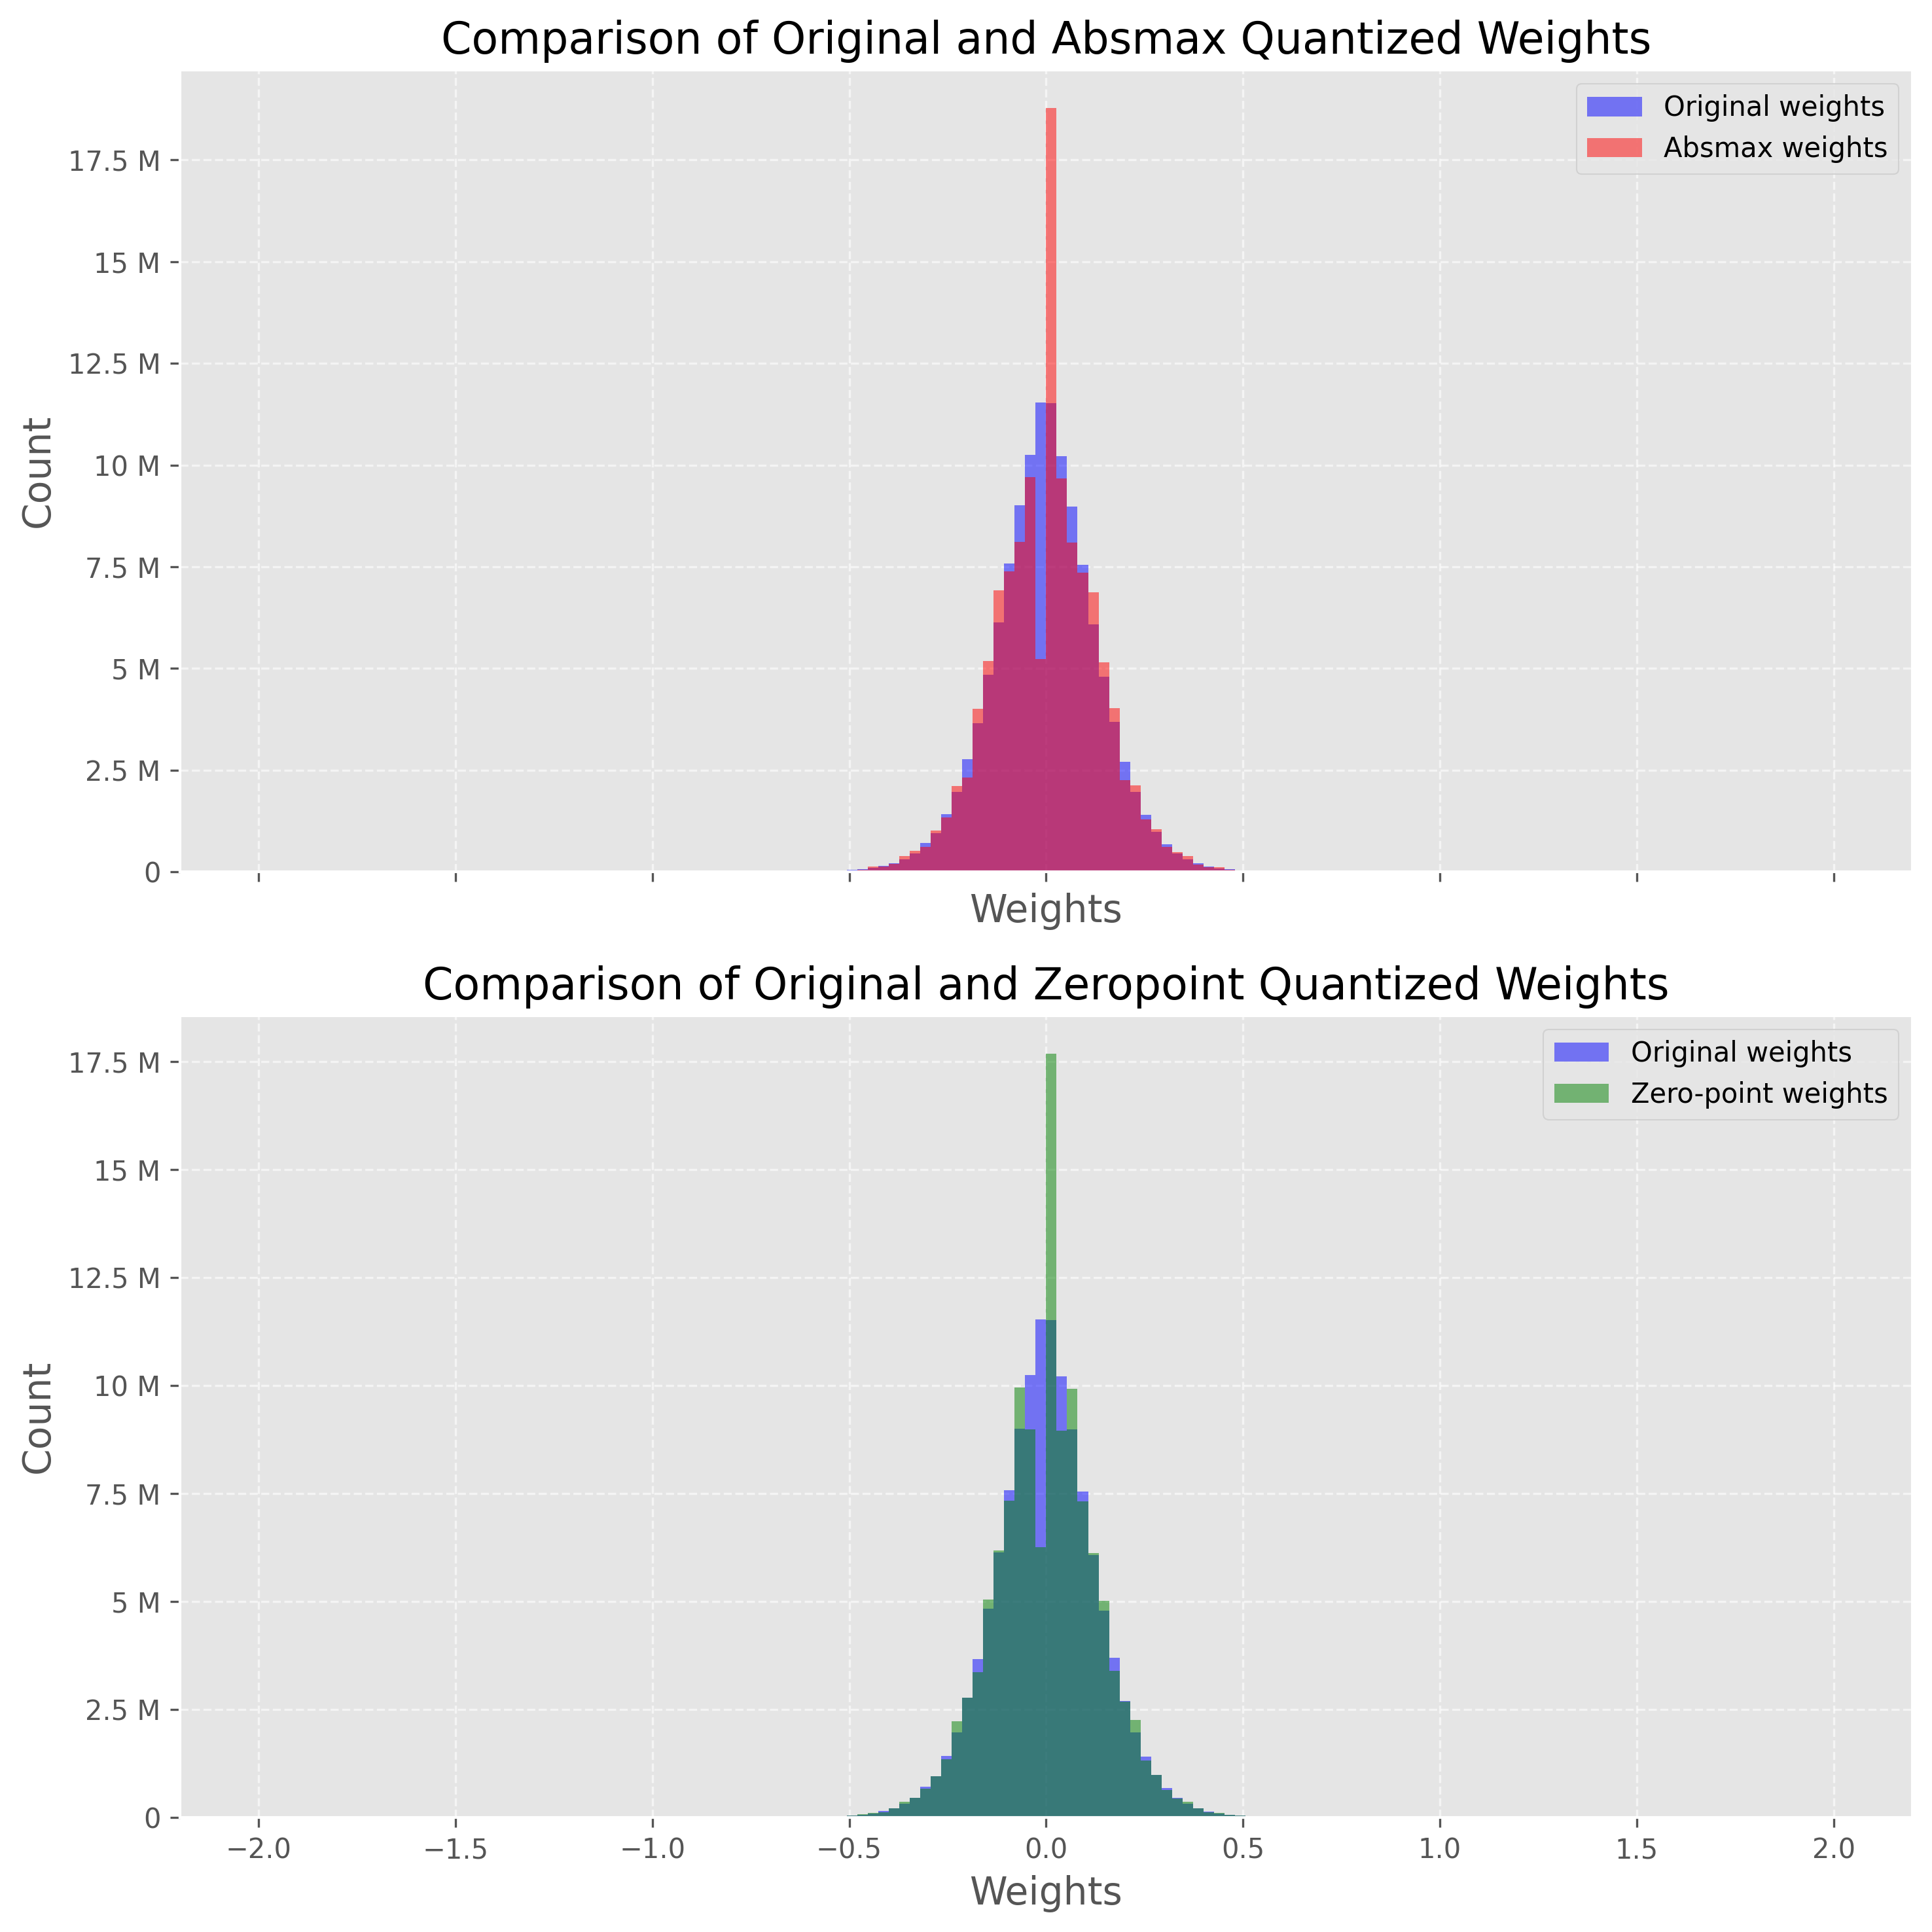

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

## 모델 예측

In [9]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_abs, "I have a dream")
zp_text       = generate_text(model_zp, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream," he said. "You have a dream. The dream of a great guy. You dream that you'll be one day an NFL superstar. You dream that you'll be one day a quarterback in the NFL. You dream that
--------------------------------------------------
Absmax model:
I have a dream on my hands, to have all of America become better off." It's only a dream, but it's worth it. This was an awesome time to be alive! I was really, really lucky here, I could have been
--------------------------------------------------
Zeropoint model:
I have a dream for you. We both love you.


Thank You!

I love you,

you're the coolest.


## 모델 평가
### [Perplexity](https://rfriend.tistory.com/851)
- 자연어 처리(NLP)에서 확률적 또는 통계적 모델의 품질을 평가하는데 사용되는 척도입니다.
- Perplexity 점수가 낮을수록 모델이 샘플을 예측하는 데 더 나은 것으로 간주됩니다.

우리는 원래 모델의 Perplexity가 다른 두 모델보다 약간 낮다 는 것을 알 수 있습니다. 단일 실험은 그다지 신뢰할 수 없지만 이 프로세스를 여러 번 반복하여 각 모델 간의 차이를 확인할 수 있습니다. 이론적으로 영점 양자화는 absmax보다 약간 더 좋지만 계산 비용도 더 많이 듭니다.

In [10]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, absmax_text)

print(f"Original perplexity:  {ppl.item():.2f}")
print(f"Absmax perplexity:    {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity:  7.59
Absmax perplexity:    21.52
Zeropoint perplexity: 18.08
